LSA

In [45]:
'''
Tiền xử lý dữ liệu
'''

import pandas as pd
import re
from underthesea import word_tokenize, sent_tokenize

df = pd.read_csv("D:\\Introduction to AI\\Project-AI\\active\\data\\data-1.csv")

df= df.drop(["Unnamed: 0", "Dataset"], axis=1)

# Chuyển về chữ thường
df['Document'] = df['Document'].str.lower()

def protect_numbers(text):
    return re.sub(r'(\d+)\.(\d+)', r'\1_\2', text)

def restore_numbers(text):
    return text.replace('_', '.')

df['Document_safe'] = df['Document'].apply(protect_numbers)

# Tách câu trước
df['Documents_sentences'] = df['Document_safe'].apply(lambda x: sent_tokenize(x))

# Restore số liệu
df['Documents_sentences'] = df['Documents_sentences'].apply(
    lambda sents: [restore_numbers(sent) for sent in sents]
)

# Tokenize từng câu
df['Documents_sentences_tokenized'] = df['Documents_sentences'].apply(
    lambda sents: [word_tokenize(sent, format="text") for sent in sents]
)

print(df.head())

                                            Document  \
0  đây là một trong những nội dung tại văn bản vừ...   
1  chiều 12/3 , ông vũ hùng triều , trưởng phòng ...   
2  thoạt đầu nhìn vào bức ảnh , nếu không có dấu ...   
3  khoảng 9h30 sáng 5/6 , anh đào nhật tuấn ( 30 ...   
4  liên minh tự do dân sự mỹ ( aclu ) đã nhận đượ...   

                                             Summary  \
0  Các quận , huyện , thị xã tuyên truyền bằng nh...   
1  Cháu bé được phát hiện trong tình trạng chưa c...   
2  Báo tuyết ( Panthera uncia ) được mệnh danh là...   
3  Thấy con chim bị mắc bẫy rơi xuống hồ nước , a...   
4  Loại " huyết thanh nói thật " mà CIA sử dụng đ...   

                                       Document_safe  \
0  đây là một trong những nội dung tại văn bản vừ...   
1  chiều 12/3 , ông vũ hùng triều , trưởng phòng ...   
2  thoạt đầu nhìn vào bức ảnh , nếu không có dấu ...   
3  khoảng 9h30 sáng 5/6 , anh đào nhật tuấn ( 30 ...   
4  liên minh tự do dân sự mỹ ( aclu ) đã nhận 

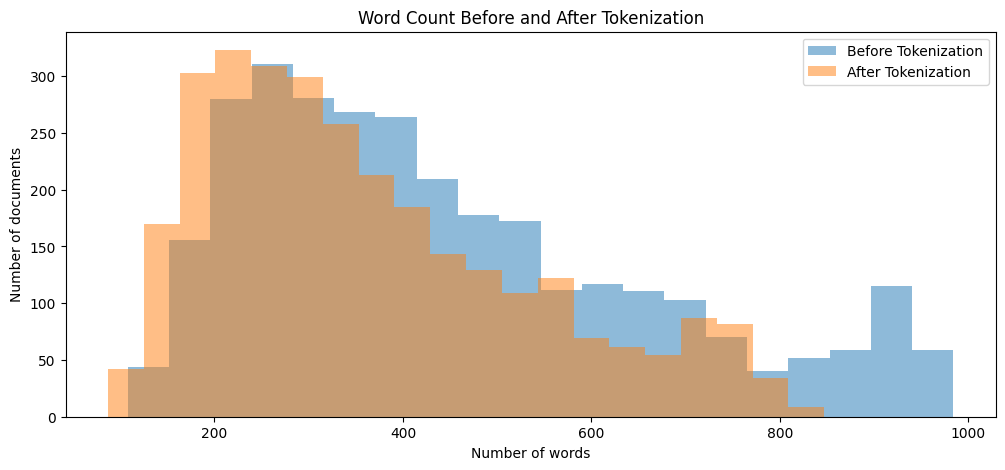

In [52]:
import matplotlib.pyplot as plt

df['length_before'] = df['Document'].apply(lambda x: len(x.split()))
df['length_after'] = df['Documents_sentences_tokenized'].apply(
    lambda sents: sum(len(sent.split()) for sent in sents)
)

plt.figure(figsize=(12,5))
plt.hist(df['length_before'], bins=20, alpha=0.5, label='Before Tokenization')
plt.hist(df['length_after'], bins=20, alpha=0.5, label='After Tokenization')
plt.xlabel('Number of words')
plt.ylabel('Number of documents')
plt.title('Word Count Before and After Tokenization')
plt.legend()
plt.show()

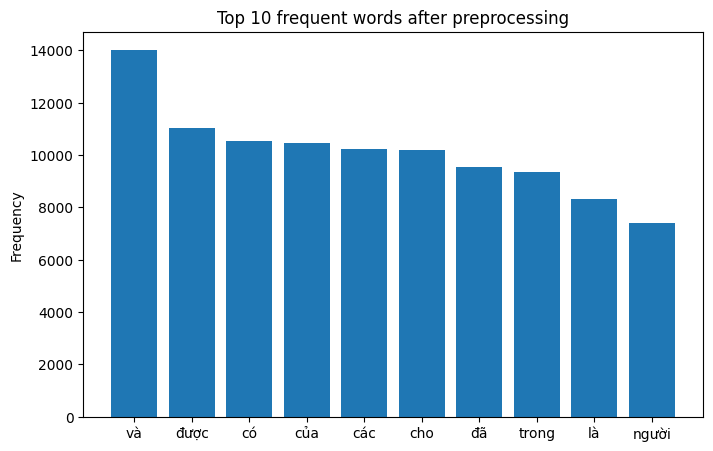

In [56]:
from collections import Counter

# Flatten tất cả từ trong các câu đã tokenize
all_words = [word for doc in df['Documents_sentences_tokenized'] for sent in doc for word in sent.split()]

# Loại bỏ punctuation nếu cần
punctuations = {'.', '!', '?', ',', ':', ';', '(', ')', '-', '"', "'"}
all_words = [w for w in all_words if w not in punctuations]

most_common = Counter(all_words).most_common(10)

words, counts = zip(*most_common)

plt.figure(figsize=(8,5))
plt.bar(words, counts)
plt.title('Top 10 frequent words after preprocessing')
plt.ylabel('Frequency')
plt.show()

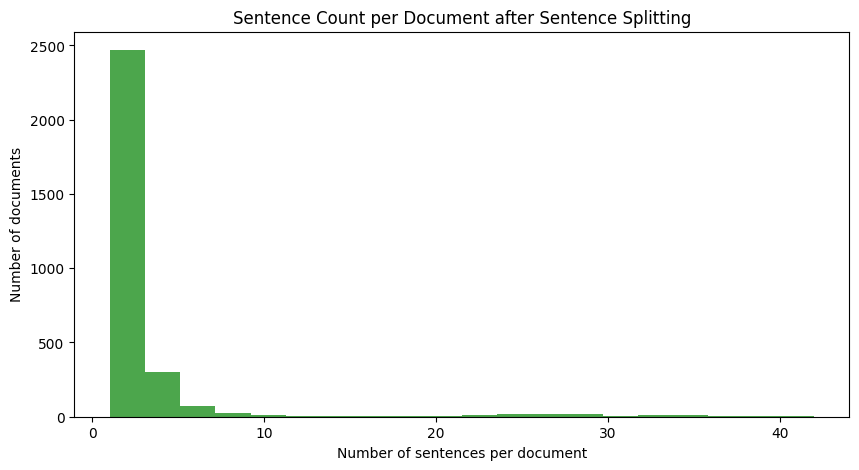

In [58]:
df['num_sentences'] = df['Documents_sentences_tokenized'].apply(len)

plt.figure(figsize=(10,5))
plt.hist(df['num_sentences'], bins=20, alpha=0.7, color='green')
plt.xlabel('Number of sentences per document')
plt.ylabel('Number of documents')
plt.title('Sentence Count per Document after Sentence Splitting')
plt.show()

In [59]:
'''
Biểu diễn câu bằng TF - IDF
'''

from sklearn.feature_extraction.text import TfidfVectorizer

# Gộp tất cả câu thành một danh sách
all_sentences = [sentence for doc in df['Documents_sentences_tokenized'] for sentence in doc]

# Khởi tạo TF-IDF
vectorizer = TfidfVectorizer(
    max_features=5000,   # số từ tối đa để giảm ma trận quá lớn
    stop_words=None      # nếu bạn đã xóa stopwords trước đó
)

# Biến tất cả câu thành ma trận TF-IDF
tfidf_matrix = vectorizer.fit_transform(all_sentences)
print(tfidf_matrix.shape)
vectorizer.get_feature_names_out()

(9490, 5000)


array(['000', '01', '02', ..., 'ứng_dụng', 'ứng_phó', 'ứng_xử'],
      shape=(5000,), dtype=object)

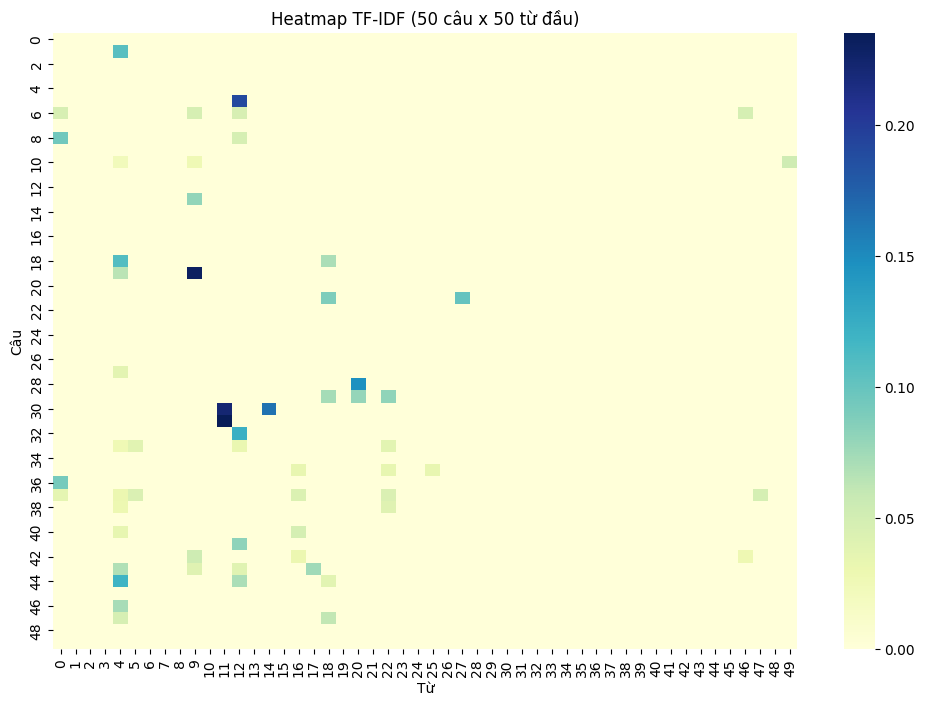

In [60]:
import seaborn as sns

tfidf_sample = tfidf_matrix[:50,:50].toarray()

plt.figure(figsize=(12,8))
sns.heatmap(tfidf_sample, cmap="YlGnBu")
plt.title("Heatmap TF-IDF (50 câu x 50 từ đầu)")
plt.xlabel("Từ")
plt.ylabel("Câu")
plt.show()

In [61]:
'''
Áp dụng LSA
'''

from sklearn.decomposition import TruncatedSVD

k = 5

svd = TruncatedSVD(n_components=k, random_state=42)

lsa_matrix = svd.fit_transform(tfidf_matrix)
print(lsa_matrix.shape)

terms = vectorizer.get_feature_names_out()
n_top_words = 10  # số từ quan trọng muốn hiển thị

for topic_idx, topic in enumerate(svd.components_):
    top_terms = sorted(zip(terms, topic), key=lambda x: abs(x[1]), reverse=True)[:n_top_words]
    top_terms = [(word, round(float(weight), 3)) for word, weight in top_terms]
    print(f"Top words for topic {topic_idx}: {top_terms}")
    print()

(9490, 5)
Top words for topic 0: [('và', 0.197), ('được', 0.17), ('các', 0.165), ('có', 0.162), ('của', 0.161), ('cho', 0.159), ('đã', 0.155), ('trong', 0.147), ('người', 0.143), ('bệnh_viện', 0.138)]

Top words for topic 1: [('bệnh_viện', 0.279), ('bé', 0.191), ('những', -0.168), ('cháu', 0.164), ('loài', -0.153), ('chị', 0.143), ('cấp_cứu', 0.137), ('nghiên_cứu', -0.137), ('huyện', 0.135), ('các', -0.133)]

Top words for topic 2: [('con', 0.364), ('cá', 0.267), ('bệnh_viện', -0.233), ('bệnh_nhân', -0.222), ('bác_sĩ', -0.178), ('các', -0.175), ('y_tế', -0.17), ('anh', 0.16), ('bệnh', -0.137), ('bé', 0.124)]

Top words for topic 3: [('bé', 0.282), ('tôi', 0.275), ('cá', -0.215), ('tỉnh', -0.154), ('cháu', 0.153), ('huyện', -0.151), ('không', 0.141), ('ông', -0.128), ('bác_sĩ', 0.128), ('xã', -0.127)]

Top words for topic 4: [('cá', 0.354), ('bệnh_nhân', 0.324), ('bé', -0.254), ('bệnh_viện', 0.234), ('cháu', -0.205), ('bác_sĩ', 0.192), ('máu', 0.178), ('anh', 0.175), ('chó', -0.157), ('

In [63]:
import numpy as np

# Tính score cho từng câu
sentence_scores = np.sum(np.abs(lsa_matrix), axis=1)

# Lấy 10 câu quan trọng nhất
top_indices = np.argsort(sentence_scores)[-10:][::-1]  # sắp xếp giảm dần
for i in top_indices:
    print(all_sentences[i], sentence_scores[i])
    print()

video : con cá_quý được anh sử_nhốt trong khoang thuyềnrạng sáng nay , anh đậu văn_sử ( 24 tuổi , trú thị_xã cửa_lò , nghệ_an ) cùng vợ chèo thuyền thả lưới trên sông cấm_đoạn qua thị_xã cửa_lò thì phát_hiện con cá lớn dính lưới . đưa cá lên thuyền , anh sử ngạc_nhiên vì giống loài cá_sủ vàng quý_hiếm . thân cá có màu vàng óng ánh dài gần 1 m , phần bụng màu trắng , vây đỏ . cá nặng 8,1 kg . ông võ_minh vỹ , chủ_tịch ubnd phường nghi_tân , cho_hay đã trực_tiếp tới xem con cá và thấy " đúng là giống cá sủ vàng , tuy_nhiên chưa_thể khẳng_định chính_xác " . con cá mà vợ_chồng ảnh sử vừa bắt được . hay tin anh vợ_chồng ngư_dân bắt được cá_quý , cả trăm người_dân địa_phương đã kéo tới xem ; một_số thương_lái trả_giá_cả chục triệu đồng để mua con cá nhưng gia_chủ chưa đồng_ý . cá sủ vàng phân_bố chủ_yếu ở vùng_biển ấn_độ , việt_nam , indonesia , sri lanka , trung_quốc và có giá_trị kinh_tế rất cao . mùa sinh_sản vào tháng 1 - 4 và 9-10_âm_lịch , loài cá này thường vào các vùng cửa_sông nước_

In [97]:
summary_ratio = 0.3  # 30% số câu

# Chứa summary cho từng văn bản
summaries = []

for doc_idx, sentences in enumerate(df['Documents_sentences_tokenized']):
    # Lấy score của các câu thuộc văn bản này
    start_idx = sum(df['Documents_sentences'].iloc[:doc_idx].apply(len))
    end_idx = start_idx + len(sentences)
    scores = sentence_scores[start_idx:end_idx]

    # Số câu muốn chọn
    k = max(1, int(len(sentences) * summary_ratio))

    # Lấy indices các câu quan trọng nhất
    top_sentence_indices = np.argsort(scores)[-k:]

    # Sắp xếp theo thứ tự xuất hiện trong văn bản
    top_sentence_indices = sorted(top_sentence_indices)

    # Tạo summary
    summary = ' '.join([sentences[i] for i in top_sentence_indices])
    summaries.append(summary)

# Thêm vào dataframe
df['Summary_LSA'] = summaries

# Kiểm tra kết quả
for i in range(10):
    print("Original Document:\n", df['Document'].iloc[i][:300], "...\n")
    print("Summary:\n", df['Summary_LSA'].iloc[i], "\n")
    print("="*80)

Original Document:
 đây là một trong những nội dung tại văn bản vừa được ubnd tp hà nội ban hành về việc tăng cường công tác quản lý nuôi , giết mổ , kinh doanh và sử dụng thịt chó , mèo trên địa bàn .theo đó , các sở , ngành trên địa bàn phải vào cuộc ngay để hướng tới thay đổi thói quen của người dân khi dùng chó , m ...

Summary:
 hoàn_toàn có_thể thay_đổi một thói_quen xấu nếu được truyền_thông tốt , mà việc bỏ ăn_tiết_canh là một ví_dụ . trước_đây các hàng_quán " lòng lợn , tiết_canh " mọc khắp_nơi bởi đây là món khoái_khẩu của dân nhậu . nhưng khi báo_chí đưa tin nhiều về các ca nhiễm_khuẩn cầu lợn gây tử_vong với những triệu_chứng khủng_khiếp , gần như món ăn này bị tẩy_chay , hiện rất ít người dùng món ăn này " - vị này nói . trong khi đó , không_chỉ những bạn trẻ nuôi chó cảnh làm thú_cưng phản_đối việc xem chó là một loại thực_phẩm , mà ngay cả những người từng xem thịt chó là món " khoái_khẩu " cũng ủng_hộ việc bỏ ăn thịt chó . dù từng ăn thịt chó , anh nguyễn_văn_thuận , mộ

In [98]:
# In văn bản đầu tiên
with open("D:\\Introduction to AI\\Project-AI\\active\\data\\data_summaries.txt", "w", encoding="utf-8") as f:
    for i in range(min(1000, len(df))):
        f.write(f"Document {i+1}:\n")
        f.write("Original: " + df['Document'].iloc[i] + "\n")
        f.write("Summary: " + df['Summary_LSA'].iloc[i] + "\n")
        f.write("="*80 + "\n")

In [95]:
from rouge import Rouge
import pandas as pd

rouge = Rouge()
scores_list = []

for i in range(len(df)):
    reference = df['Summary'].iloc[i]          # summary chuẩn
    generated = df['Summary_LSA'].iloc[i]     # summary LSA
    scores = rouge.get_scores(generated, reference)[0]
    scores_list.append(scores)

# Tạo dataframe để xem
df_rouge = pd.DataFrame(scores_list)
print(df_rouge.head())

# Tách các thành phần rouge-1, rouge-2, rouge-l
rouge_1 = df_rouge['rouge-1'].apply(pd.Series)
rouge_2 = df_rouge['rouge-2'].apply(pd.Series)
rouge_l = df_rouge['rouge-l'].apply(pd.Series)

# Tính trung bình
avg_rouge_1 = rouge_1.mean()
avg_rouge_2 = rouge_2.mean()
avg_rouge_l = rouge_l.mean()

# In ra console
print("Average ROUGE-1:\n", avg_rouge_1)
print("Average ROUGE-2:\n", avg_rouge_2)
print("Average ROUGE-L:\n", avg_rouge_l)

                                             rouge-1  \
0  {'r': 0.5102040816326531, 'p': 0.1404494382022...   
1  {'r': 0.8571428571428571, 'p': 0.1058823529411...   
2  {'r': 0.48484848484848486, 'p': 0.102564102564...   
3  {'r': 0.8333333333333334, 'p': 0.1401869158878...   
4  {'r': 0.8709677419354839, 'p': 0.1144067796610...   

                                             rouge-2  \
0  {'r': 0.14035087719298245, 'p': 0.031620553359...   
1  {'r': 0.6666666666666666, 'p': 0.0542635658914...   
2  {'r': 0.14285714285714285, 'p': 0.022123893805...   
3  {'r': 0.5263157894736842, 'p': 0.0699300699300...   
4  {'r': 0.6129032258064516, 'p': 0.0467980295566...   

                                             rouge-l  
0  {'r': 0.4489795918367347, 'p': 0.1235955056179...  
1  {'r': 0.8095238095238095, 'p': 0.1, 'f': 0.178...  
2  {'r': 0.45454545454545453, 'p': 0.096153846153...  
3  {'r': 0.8333333333333334, 'p': 0.1401869158878...  
4  {'r': 0.8387096774193549, 'p': 0.1101694915254..

In [93]:
# Ghi kết quả ra file
with open("D:\\Introduction to AI\\Project-AI\\active\\data\\rouge_scores.txt", "w", encoding="utf-8") as f:
    f.write("===== ROUGE Scores (documents) =====\n")
    f.write(df_rouge.map(
        lambda x: {k: round(v, 3) for k, v in x.items()}
    ).to_string())

    f.write("\n\n===== Average ROUGE-1 =====\n")
    f.write(avg_rouge_1.round(3).to_string())

    f.write("\n\n===== Average ROUGE-2 =====\n")
    f.write(avg_rouge_2.round(3).to_string())

    f.write("\n\n===== Average ROUGE-L =====\n")
    f.write(avg_rouge_l.round(3).to_string())

<Figure size 1200x600 with 0 Axes>

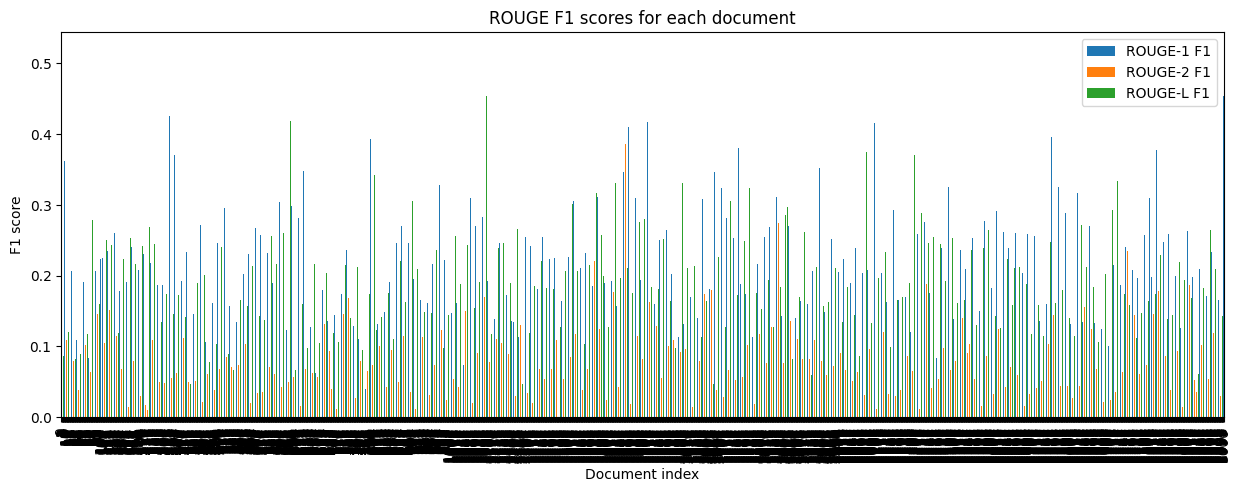

In [77]:
# Gộp lại dataframe trực quan
df_visual = pd.DataFrame({
    'ROUGE-1 F1': rouge_1['f'],
    'ROUGE-2 F1': rouge_2['f'],
    'ROUGE-L F1': rouge_l['f']
})

# Vẽ biểu đồ cho từng văn bản
plt.figure(figsize=(12,6))
df_visual.plot(kind='bar', figsize=(15,5))
plt.xlabel('Document index')
plt.ylabel('F1 score')
plt.title('ROUGE F1 scores for each document')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show()

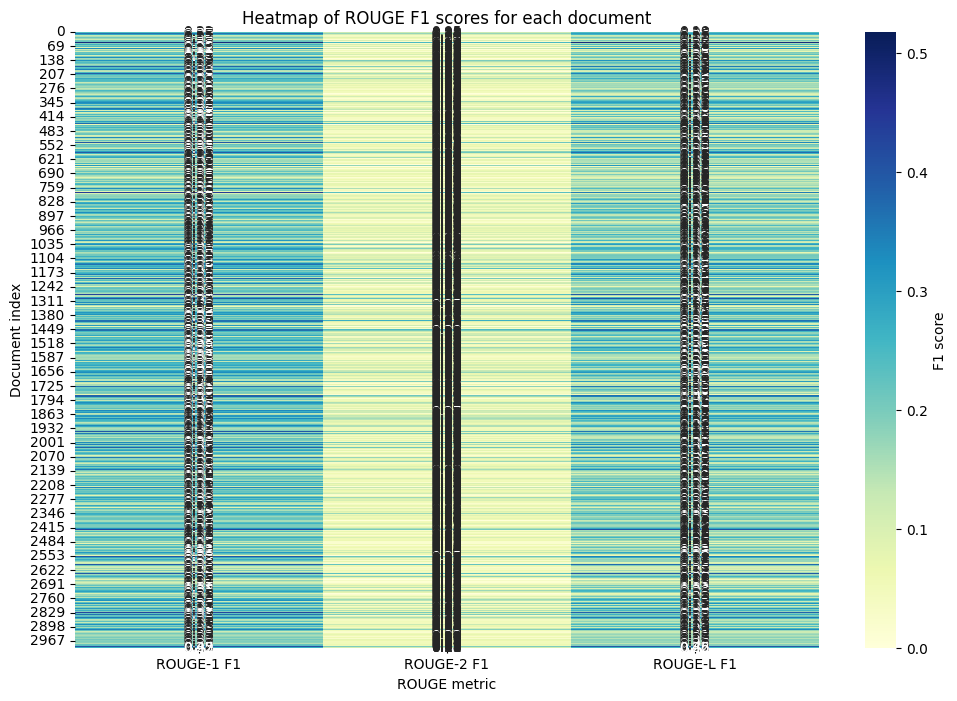

In [76]:
plt.figure(figsize=(12,8))
sns.heatmap(df_visual, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': 'F1 score'})
plt.title("Heatmap of ROUGE F1 scores for each document")
plt.xlabel("ROUGE metric")
plt.ylabel("Document index")
plt.show()

TEST